Dieses Notebook ist angelehnt an das Buch *Python Data Science Handbook* von Jake VanderPlas, auch verfügbar auf [GitHubPages](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic).

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Praktikum: Session 6
In dieser Session wollen wir weiter mit den in Session 5 verwendeten Daten der Fahrradfahrten über die Seattle Fremont Bridge arbeiten.

Konkret wollen wir:

1.  Die Daten "besser treffen", d.h. ein Modell erstellen, das die gesamten Daten besser lernen kann.

Das stellt lediglich eine weitere Verbesserung der Arbeit des letzten Praktikums dar.

2.  Ein Modell mit historischen Daten trainieren, welches dann Vorhersagen für die Zukunft treffen kann.

Das ist eine prinzipiell andere Aufgabenstellung.

*Im Folgenden ist eine Lösung der Session 5 vorhanden, auf welcher wir unten aufbauen werden.*

## Praktikum: Session 5
In dieser Session geht es darum, lineare Modelle besser kennenzulernen, indem wir insbesondere deren Parameter interpretieren.

Als Anwendungsfall betrachten wir die Anzahl der Fahrradfahrten über die Fremont Bridge in Seattle (dort sind entsprechende Sensoren installiert und die Daten seit Oktober 2012 verfügbar). Ziel ist es, diese Anzahl der Fahrten für einen gegebenen Tag vorherzusagen. Zu diesem Zweck wollen wir ein lineares Modell erstellen.

## 1. (Roh-)Daten
Die Rohdaten der Fremont Bridge können einfach heruntergeladen werden:

In [0]:
#!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

In [0]:
import pandas as pd
counts = pd.read_csv('/content/FremontBridge.csv', index_col='Date', parse_dates=True)

In [4]:
counts.tail()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-10-31 19:00:00,111.0,44.0,67.0
2019-10-31 20:00:00,52.0,17.0,35.0
2019-10-31 21:00:00,41.0,16.0,25.0
2019-10-31 22:00:00,32.0,14.0,18.0
2019-10-31 23:00:00,18.0,6.0,12.0


Offenbar sind hier die Überquerungen in einem Stundenraster vorhanden. Außerdem ist neben dem Gesamtverkehr auch noch die Aufteilung in östliche und westliche Sput vorhanden (westlich: Richtung Downtown). Wir wollen diese Daten noch abändern, denn:
- Wir sind nur am gesamten Verkehr interessiert.
- Wir interessieren uns nur für die gesamten Überquerungen eines ganzen Tages.

Für diese für uns relevanten Informationen legen wir einen DataFrame ``daily`` an:

In [0]:
daily = counts.resample('d').sum()
daily['Total'] = daily['Fremont Bridge Total']
daily = daily[['Total']]

In [6]:
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


Basierend darauf können wir noch kein Modell erstellen, wir werden weitere Daten brauchen.
- Überlegen Sie, von welchen Einflussgrößen der tägliche Fahrradverkehr abhängen könnte.

Folgende Daten wollen wir als Features verwenden:
1. Wochentag
2. Feiertag ja/nein
3. Zeitpunkt im Jahr (genauer: Stunden mit Tageslicht)
4. Temperatur
5. Niederschlag
6. Trend von Jahr zu Jahr

### 1. Wochentag
Hierfür brauchen wir keine neuen Daten, denn die Information ist implizit mit dem Datum bereits vorhanden. Allerdings müssen wir sie extrahieren, denn sonst kann sie ein lineares Modell nicht bekommen (da nichtlinearer, periodischer Zusammenhang).
Wir wollen für jeden Wochentag eine eigene Spalte anlegen, die genau dann eine 1 enthält, wenn der aktuelle Tag dieser Wochentag ist, sonst soll sie 0 enthalten.

* Hinweis: ``daily.index`` gibt nur den Index des DataFrame ``daily`` zurück. In diesem Fall besteht dieser aus kalendarischen Daten, welche direkt in Form eine ``DatetimeIndex`` vorliegen. Das ist praktisch, denn solch ein ``DatetimeIndex`` hat die Methode ``dayofweek``, d.h. ``daily.index.dayofweek`` gibt die Information über den Wochentag zurück.

In [7]:
daily.index.dayofweek

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', name='Date', length=2585)

In [0]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(int)

In [9]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0
2012-10-04,3475.0,0,0,0,1,0,0,0
2012-10-05,3148.0,0,0,0,0,1,0,0
2012-10-06,2006.0,0,0,0,0,0,1,0
2012-10-07,2142.0,0,0,0,0,0,0,1


### 2. Feiertage
Diese Information ist rein aus dem Datum noch nicht ablesbar, wir brauchen zusätzlich noch einen Feiertagskalender. Dieser wird im Folgenden eingelesen und unserem DataFrame ``daily`` hinzugefügt.
- Untersuchen Sie, wie dies geschieht.

In [0]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2019')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [11]:
daily['holiday'].fillna(0, inplace=True)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0,0.0
2012-10-04,3475.0,0,0,0,1,0,0,0,0.0
2012-10-05,3148.0,0,0,0,0,1,0,0,0.0
2012-10-06,2006.0,0,0,0,0,0,1,0,0.0
2012-10-07,2142.0,0,0,0,0,0,0,1,0.0


### 3. Tageslichtstunden
Auch die Information, wie lang die einzelnen Tage sind (Tageslichtstunden), ist in den Daten noch nicht vorhanden. Diese kann aber aus dem Datum und der geographischen Lage *berechnet* werden. In der unten stehenden Funktion ``hours_of_daylight`` ist die astronomische Standardberechnung implementiert. Nutzen Sie diese, um dem DataFrame ``daily`` eine weitere Spalte ``daylight_hrs`` hinzuzufügen, welche diese Information enthält. Stellen Sie diese neue Spalte graphisch dar, indem Sie ``daily['daylight_hrs'].plot()`` verwenden.

*Hinweis:* Mit dem Befehl ``map(hours_of_daylight, Daten)`` können Sie die Funktion ``hours_of_daylight`` auf Daten anwenden, die Funktion ``list(...)`` macht daraus eine Liste.

In [0]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

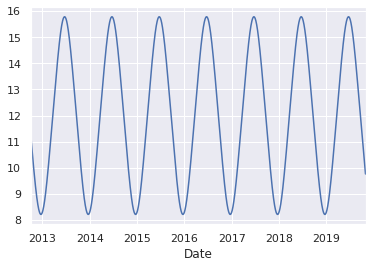

In [13]:
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily['daylight_hrs'].plot();

### 4. Temperatur / 5. Niederschlag
Diese Informationen sind ganz offensichtlich nicht in den Daten vorhanden und kann daraus auch nicht berechnet werden. Wir müssen daher eine zweite Datenquelle verwenden. Betrachten Sie diese.

In [0]:
weather = pd.read_csv('/content/BicycleWeather2019.csv', index_col='DATE', parse_dates=True)

In [15]:
weather.head()

,STATION,NAME,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT18,WT22
DATE,,,,,,,,,,,,,,,,,,,,
2012-10-03,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,NaN,18.9,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-04,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,NaN,18.9,8.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-05,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,NaN,21.7,8.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-06,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,NaN,23.9,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-07,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,NaN,23.9,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Bei der Durchschittstemperatur gibt es einige fehlende Daten (wie könnte man das herausfinden?). Legen Sie eine neue Spalte ``weather['Temp (C)']`` an, welche falls vorhanden die Durchschnittstemperatur ``TAVG`` und ansonsten als Näherung hierfür den Mittelwert aus ``TMIN`` und ``TMAX``.

*Hinweis:* Mit ``weather.loc[Zeilen, Spalten]`` kann man (auch schreibend) auf die durch Zeilen und Spalten spezifizierten Einträge zugreifen. ``weather['Temp (C)'].isnull()`` kann für die Zeilenwahl hilfreich sein.

In [0]:
weather['Temp (C)'] = weather['TAVG']

In [0]:
weather.loc[weather['Temp (C)'].isnull(), 'Temp (C)'] = 0.5*(weather['TMAX'] + weather['TMIN'])

In [18]:
weather.tail()

,STATION,NAME,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT04,WT05,WT08,WT09,WT13,WT14,WT16,WT18,WT22,Temp (C)
DATE,,,,,,,,,,,,,,,,,,,,,
2019-10-27,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,NaN,12.8,3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.35
2019-10-28,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,6.1,11.7,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.10
2019-10-29,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,6.2,10.0,1.7,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6.20
2019-10-30,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,5.8,11.7,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.80
2019-10-31,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",0.0,0.0,0.0,6.2,11.7,1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.20


Was den Niederschlag angeht, so wäre es evtl. auch relevant explizit zu wissen, ob es an einem Tag regnet (also ``PRCP!=0``) oder eben nicht (also ``PRCP==0``). Legen Sie hierfür eine neue Spalte ``weather[dry day]`` an, die an trockenen Tagen 1 enthält und sonst 0.

*Hinweis:* Ein Vergleich wie ``PRCP==0`` liefert einen Wahrheitswert, d.h. ``True`` oder ``False`` zurück. Damit kann unser Modell aber nicht rechnen. Ein nachgestelltes ``.astype(int)`` sorgt dafür, dass ``True`` als 1 und ``False`` als 0 angegeben wird.

In [0]:
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

Diese Wetterdaten sollen nun den ``daily`` Daten hinzugefügt werden. Hierfür gibt es die Methode ``join``: Durch den Befehl ``df1.join(df2)`` wird ein neuer DataFrame erstellt, welcher die Daten aus ``df1`` und die Daten aus ``df2`` zusammengefügt enthält. Dabei sollten die Indices der beiden DataFrames übereinstimmen.

In [0]:
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

### 6. Trend von Jahr zu Jahr
Um einen etwa vorhandenen langfristigen Trend ggf. mit aufnehmen zu können, soll eine weiteres Feature angeben, wie viele Tage seit Beginn der Messung vergangen sind. Damit haben wir eine monoton steigende Größe.

Legen Sie ein Feature ``annual`` an, das die beschriebene Größe skaliert mit 1/365 angibt. D.h. ``annual`` soll nach einem Jahr den Wert 1, nach zwei Jahren den Wert 2  usw. haben.

*Hinweis:* Das Datum ist im Index gespeichert, auf den mit ``daily.index`` zugegriffen werden kann. ``daily.index[0]`` gibt das erste Datum als ``Timestamp`` zurück. Mit solchen Timestamps kann ganz einfach gerechnet werden, so gibt etwa die Differenz zweier Timestamps den dazwischen liegenden Zeitraum an (als ``Timedelta``-Objekt, mit ``.days`` extrahiert man daraus die Tage).

In [0]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

In [22]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0,0.0,11.277359,0.0,13.35,1,0.000000
2012-10-04,3475.0,0,0,0,1,0,0,0,0.0,11.219142,0.0,13.60,1,0.002740
2012-10-05,3148.0,0,0,0,0,1,0,0,0.0,11.161038,0.0,15.30,1,0.005479
2012-10-06,2006.0,0,0,0,0,0,1,0,0.0,11.103056,0.0,15.85,1,0.008219
2012-10-07,2142.0,0,0,0,0,0,0,1,0.0,11.045208,0.0,15.85,1,0.010959


Wir prüfen, ob nun noch irgendwo Werte fehlen:

In [23]:
daily.isna().sum()

Total           0
Mon             0
Tue             0
Wed             0
Thu             0
Fri             0
Sat             0
Sun             0
holiday         0
daylight_hrs    0
PRCP            0
Temp (C)        0
dry day         0
annual          0
dtype: int64

## 2. Modell
Entnehmen Sie aus ``daily`` die Features Matrix ``X`` und den Labels Vektor ``y``.

In [0]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

Trainieren Sie ein ``LinearRegression`` Modell auf die Daten. Setzen Sie den Hyperparameter ``fit_intercept=False``. Plotten Sie die erhaltenen Ergebnisse und vergleichen Sie diese (im Plot) mit den echten Daten.

*Hinweis:* Sie können (eine Auswahl) eines DataFrames ``df`` einfach plotten durch ``df[['Item_1', ..., 'Item_N']].plot(alpha=0.5)``. Dabei sorgt ``alpha=0.5`` für einen nicht deckenden Plot, so dass sich ggf. überlagernde Linien sichtbar bleiben.

In [0]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['pred_lin'] = model.predict(X)

In [32]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,pred_lin
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0,0,1,0,0,0,0,0.0,11.277359,0.0,13.35,1,0.000000,3477.159975
2012-10-04,3475.0,0,0,0,1,0,0,0,0.0,11.219142,0.0,13.60,1,0.002740,3362.022249
2012-10-05,3148.0,0,0,0,0,1,0,0,0.0,11.161038,0.0,15.30,1,0.005479,3139.375991
2012-10-06,2006.0,0,0,0,0,0,1,0,0.0,11.103056,0.0,15.85,1,0.008219,1789.301694
2012-10-07,2142.0,0,0,0,0,0,0,1,0.0,11.045208,0.0,15.85,1,0.010959,1685.788194


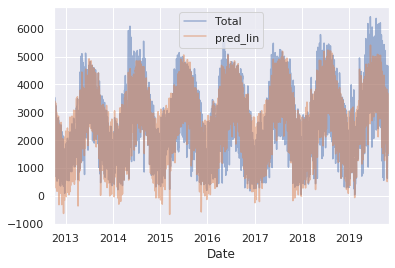

In [26]:
daily[['Total', 'pred_lin']].plot(alpha=0.5);

Betrachten Sie auch kleinere Zeiträume im Plot (im DataFrame ``df`` können durch ``df.loc['Startdatum':'Enddatum']`` nur die entsprechenden Daten gefiltert werden).

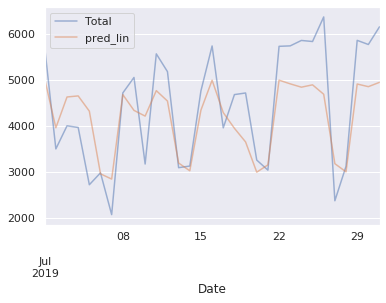

In [27]:
daily[['Total', 'pred_lin']].loc['2019-07-01':'2019-07-31'].plot(alpha=0.5)

Da wir ein lineares Modell verwendet haben, können wir uns die einzelnen Koeffizienten gut vorstellen; diese geben jeweils an, wie stark das entsprechende Feature in den vorhergesagten Wert eingeht. Die Koeffizienten sind nach dem Training in ``model.coef_`` verfügbar und beziehen sich der Reihe nach auf die Features. Hier eine übersichtliche tabellarische Darstellung:

In [28]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon              516.699731
Tue              646.526145
Wed              616.197206
Thu              488.512012
Fri              142.737167
Sat            -1242.788064
Sun            -1339.828242
holiday        -1266.454789
daylight_hrs     115.494133
PRCP             -28.145238
dry day          540.505775
Temp (C)          76.253795
annual            75.852628
dtype: float64

- Interpretieren Sie diese Daten.
- Um die Güte dieser Abhängigkeiten einschätzen zu können, brauchen wir die Standardabweichungen dieser Werte. Diese erhalten wir, indem wir das Modell mehrfach (z.B. 1000 Mal) auf zufällig ausgewählten Daten trainieren. Dadurch erhalten wir für jeden Koeffizienten 1000 Werte, davon bestimmen wir die Standardabweichung.

In [0]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

In [30]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon            517.0   62.0
Tue            647.0   61.0
Wed            616.0   62.0
Thu            489.0   61.0
Fri            143.0   61.0
Sat          -1243.0   61.0
Sun          -1340.0   62.0
holiday      -1266.0  107.0
daylight_hrs   115.0    7.0
PRCP           -28.0    2.0
dry day        541.0   25.0
Temp (C)        76.0    3.0
annual          76.0    6.0


Interpretieren Sie diese Daten.

## Start Session 6
Im ertsen Teil wollen wir nun versuchen, ob wir die vorhandenen Daten mit einem anderen Modell besser lernen können.

Verwenden Sie ``Ridge`` und ``Lasso`` Regression als Modell. Bestimmen Sie jeweils einen geeigneten Parameter für den Regularisierungsparameter ``alpha``. Stellen Sie das Ergebnis des Modells jeweils grafisch dar und quantifizieren Sie die Leistung des Modells, indem Sie die $R^2$-Score sowie den *Mean Squared Error* angeben.

Warum macht der Einsatz von ``Ridge`` bzw. ``Lasso`` im aktuellen Setting eigentlich **keinen Sinn**? (Wir machen es trotzdem, um etwas zu lernen...).

*Hinweis:* Die genannten Fehlermaße stehen in ``sklearn.metrics`` zur Verfügung.

### Ridge

### Lasso

### Metriken
Um die Performance der einzelnen Modelle übersichtlich darzustellen, können Sie z.B. den unten angelegten DataFrame verwenden.

In [31]:
from sklearn.metrics import r2_score, mean_squared_error

algs = ['Linear', 'Ridge', 'Lasso', 'SVR Linear', 'SVR LinearC', 'SVR2', 'SVR RBF']
metrics = ['sqrt(MSE)', 'R2']

benchmark = pd.DataFrame(index=algs, columns=metrics)
benchmark.loc[['Linear', 'Ridge', 'Lasso']] = [[np.sqrt(mean_squared_error(daily['Total'], daily['pred_lin'])), r2_score(daily['Total'], daily['pred_lin'])],
                                      [np.sqrt(mean_squared_error(daily['Total'], daily['pred_ridge'])), r2_score(daily['Total'], daily['pred_ridge'])],
                                      [np.sqrt(mean_squared_error(daily['Total'], daily['pred_lasso'])), r2_score(daily['Total'], daily['pred_lasso'])]]
benchmark

KeyError: ignored

Das ist nicht wirklich besser geworden - was aber auch kein Wunder ist, da der gewählte Regularisierungsparameter stets sehr klein ist. Das wiederum ist eigentlich klar, denn das aktuell verfolgte Ziel ist es, die Daten möglichst genau zu treffen - von Generalisierung ist (noch) keine Rede.

Daher wenden wir uns anderen Modellen zu.

### Linear SVR
Verwenden Sie eine lineare Support Vector Machine, um die Daten zu modellieren. Bestimmen Sie auch hier wieder die verwendeten Fehlermaße.

Es zeigt sich, dass dieses lineare SVR Modell *wesentlich schlechter* ist als die verwendeten linearen Modelle. Das kann so eigentlich nicht sein. Woran könnte es liegen?

*Hinweis:* Welche Hyperparameter verwendet ``SVR``? Was bewirken diese? Was wollen wir in der vorliegenden Aufgabenstellung?

### Passendere Hyperparameter für SVR
Wir betrachten nun lineare SVR und Kernel SVR mit polynomiellem Kern (Grad 2) bzw. RBF Kern. Wählen Sie hierfür jeweils einen höheren Wert für ``C``, um ein wenig regularisiertes Modell zu trainieren. Geben Sie jeweils wieder die Visualisierung und auch die obige Bewertungsmetrik an.

Verwenden Sie konkret:
- Linear: ``C``=100
- Quadratisch: ``C``=100, ``gamma``=0.1
- RBF: ``C``=5000, ``gamma``=0.1

#### Linear

#### Quadratisch

#### RBF

## Vorhersagemodell
Teilen Sie die vorliegenden Daten auf in Trainings- und Testdaten. Verwenden Sie den Zeitraum bis 31. Oktober 2018 zum Trainieren und das Jahr 01. November 2018 bis 31. Oktober 2019 zum Testen. Verwenden Sie als Modelle
- LinearRegression
- Linear SVR
- SVR mit quadratischem Kern
- SVR mit RBF Kern

Führen Sie jeweils eine Optimierung der relevantesten Hyperparameter (sofern vorhanden) durch. Stellen Sie die Vorhersage grafisch dar, zusammen mit den wahren gemessenen Werten. Geben Sie wieder die Wurzel des MSE als quantitatives Gütemaß des Modells an.

### LinearRegression

### Linear SVR

### SVR quadratisch

### SVR RBF